In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Define Limit Cycle

In [2]:
# Simulate data from a limit cycle on the unit circle

# Number of dimensions
nd = 2

# Set true ODE

# Polar coordinates version
def fdrthetdt(rthet):
    return np.array([1 - rthet[0]**2, 1])

# Rectangular coordinates version
eps = 1e-6  # small constant (to prevent divide-by-zero errors)
def fdxdt(z):
    return (((1 - (z[0]**2 + z[1]**2)) / (np.sqrt(z[0]**2 + z[1]**2) + eps)) * z[0]) - z[1] -0.35

def fdydt(z):
    return (((1 - (z[0]**2 + z[1]**2)) / (np.sqrt(z[0]**2 + z[1]**2) + eps)) * z[1]) + z[0] +0.5

## Sample simulation of ODE and trajectory from ODE

In [3]:
## Euler Setup for discrete time simulation

dt = 0.01  # bin size for Euler method (in seconds)
nsec = 20  # number of seconds
nT = int(nsec / dt)  # number of time bins


# Allocate storage
rthet = np.zeros((nd, nT))  # polar coordinates [r; theta]
zz = np.zeros((nd, nT))  # rectangular coordinates [x; y]

# Set initial conditions into matrix
rthet[:, 0] = [2, 1]  # polar
zz[:, 0] = rthet[0, 0] * np.array([np.cos(rthet[1, 0]), np.sin(rthet[1, 0])])  # rectangular

# Boolean for whether or not to plot dynamic trajectory
DYNAMICPLOT = False

# Simulate ODE in polar and rectangular coordinates using Euler method
axlm = [-2, 2, -2, 2]  # axis limits

## Run Euler Simulation
for tt in range(1, nT):

    # Rectangular coords
    zzprev = zz[:, tt - 1]
    zz[:, tt] = zzprev + dt * np.array([fdxdt(zzprev), fdydt(zzprev)])

    # Make plots (if desired)
    if DYNAMICPLOT and (tt % 25 == 0):
        plt.plot(rthet[0, :tt] * np.cos(rthet[1, :tt]), rthet[0, :tt] * np.sin(rthet[1, :tt]), 'b',
                 zz[0, :tt], zz[1, :tt], 'r--')
        plt.axis(axlm)
        plt.draw()
        plt.pause(0.01)


## Plot the Trajectory and Flow Field/ODE

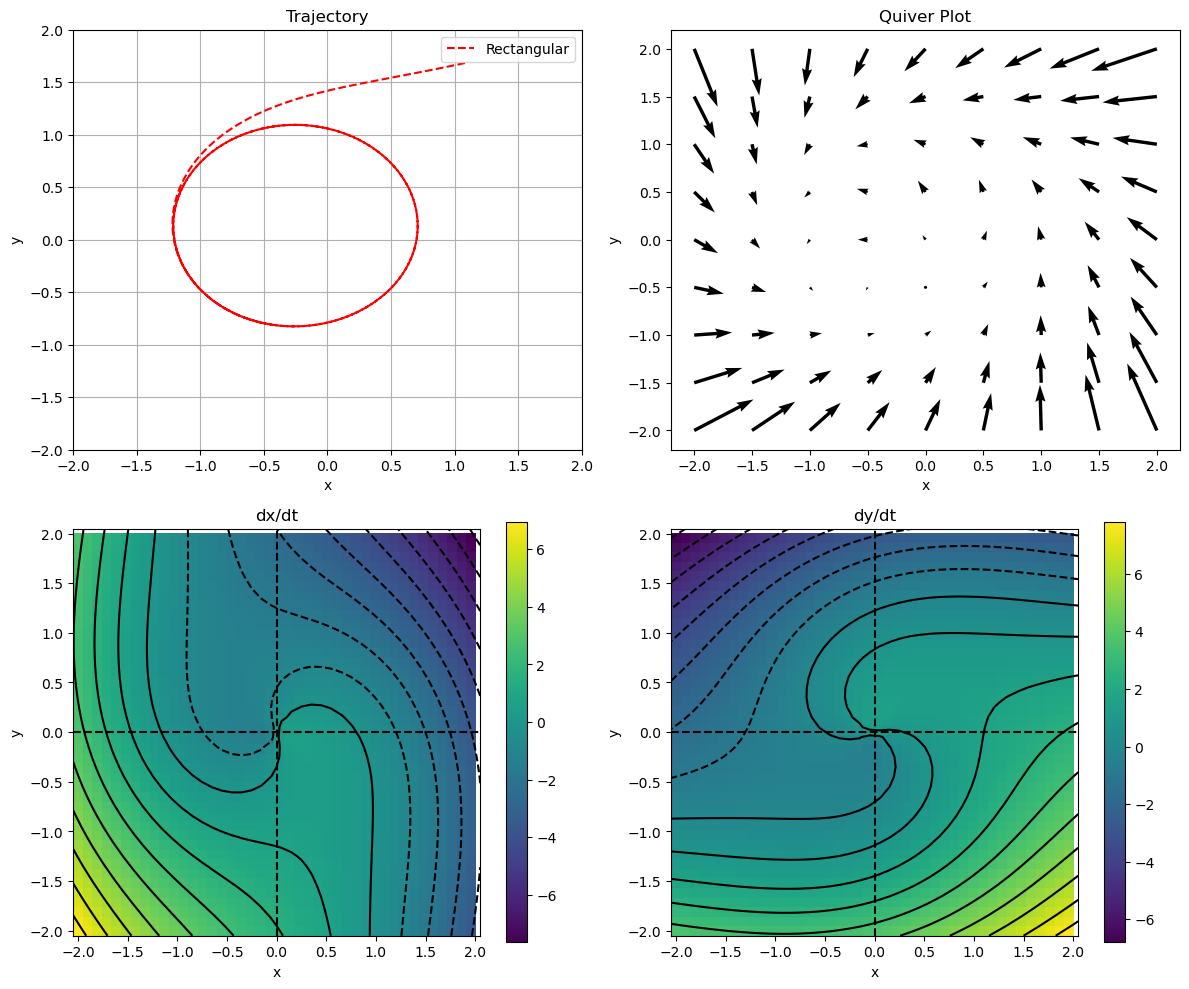

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots

# Plot 1: Dynamic trajectory
axs[0, 0].plot(zz[0, :], zz[1, :], 'r--', label='Rectangular')
axs[0, 0].set_title('Trajectory')
axs[0, 0].set_xlim(axlm[:2])
axs[0, 0].set_ylim(axlm[2:])
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot 2: Gradient field for dx/dt
x = np.arange(-2.05, 2.1, 0.1)
xx, yy = np.meshgrid(x, x)
nx = len(xx)
fx = fdxdt([xx.ravel(), yy.ravel()]).reshape(nx, nx)

im1 = axs[1, 0].imshow(fx, extent=[-2.05, 2, -2.05, 2], origin='lower', aspect='equal', cmap='viridis')
axs[1, 0].contour(x, x, fx, levels=20, colors='k')
axs[1, 0].axvline(x= 0.0, color='black', linestyle='--')
axs[1, 0].axhline(y= 0.0, color='black', linestyle='--')
axs[1, 0].set_title('dx/dt')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
fig.colorbar(im1, ax=axs[1, 0])

# Plot 3: Gradient field for dy/dt
fy = fdydt([xx.ravel(), yy.ravel()]).reshape(nx, nx)

im2 = axs[1, 1].imshow(fy, extent=[-2.05, 2, -2.05, 2], origin='lower', aspect='equal', cmap='viridis')
axs[1, 1].contour(x, x, fy, levels=20, colors='k')
axs[1, 1].axvline(x= 0.0, color='black', linestyle='--')
axs[1, 1].axhline(y= 0.0, color='black', linestyle='--')
axs[1, 1].set_title('dy/dt')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
fig.colorbar(im2, ax=axs[1, 1])

# Plot 4: Quiver plot of vector field
x2 = np.arange(-2, 2.5, 0.5)
xx2, yy2 = np.meshgrid(x2, x2)
fx2 = fdxdt([xx2.ravel(), yy2.ravel()]).reshape(len(xx2), len(xx2))
fy2 = fdydt([xx2.ravel(), yy2.ravel()]).reshape(len(xx2), len(xx2))
axs[0, 1].quiver(xx2, yy2, fx2, fy2, linewidth=1.5)
axs[0, 1].set_xlim([-2.2, 2.2])
axs[0, 1].set_ylim([-2.2, 2.2])
axs[0, 1].set_title('Quiver Plot')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')

plt.tight_layout()
plt.show()

## Set up the low-rank RNN

In [7]:
# Now make basis functions

nneur = 200  # number of neurons
nd = 2  # number of dimensions

# Make a grid over x and y
x = np.arange(-2, 2.2, 0.2)
nx = len(x)
xgrid, ygrid = np.meshgrid(x, x)
xgridvec = xgrid.ravel()
ygridvec = ygrid.ravel()

# Pick nonlinearity (tanh vs relu, for now)
useTANHvsRELU = True

# Set nonlinearity and prior stdev for m and b
if useTANHvsRELU:
    g = np.tanh  # tanh
    mstd = 2
    bstd = 0.25
else:
    g = lambda z: np.maximum(z, 0)  # relu
    mstd = 1
    bstd = 0.5

# Set m vector and input b
mmat = np.random.randn(nneur, nd) * mstd  # weight matrix
b = np.random.randn(nneur, 1) * bstd  # bias vector

# Evaluate target ODE for dx/dt and dy/dt
fx = fdxdt([xgridvec, ygridvec])  # dx/dt
fy = fdydt([xgridvec, ygridvec])  # dy/dt
Ytarg = np.vstack((fx, fy)).T  # target for least-squares regression

# Create design matrix

Xd = g(xgridvec.reshape(-1,1)@ mmat[:, 0].reshape(-1,1).T + b.T+ ygridvec.reshape(-1,1)@ mmat[:, 1].reshape(-1,1).T + b.T)

# Solve for n vector for each dimension using ridge regression
lambda_ = 0.001  # ridge parameter
nmat = np.linalg.solve(Xd.T @ Xd + lambda_ * np.eye(nneur), Xd.T @ Ytarg)
fxfit = Xd @ nmat[:, 0]
fyfit = Xd @ nmat[:, 1]

In [8]:
print("Design matrix shape: ", Xd.shape)
print("Target shape: ", Ytarg.shape)

Design matrix shape:  (441, 200)
Target shape:  (441, 2)


## Plot some 2-d basis functions

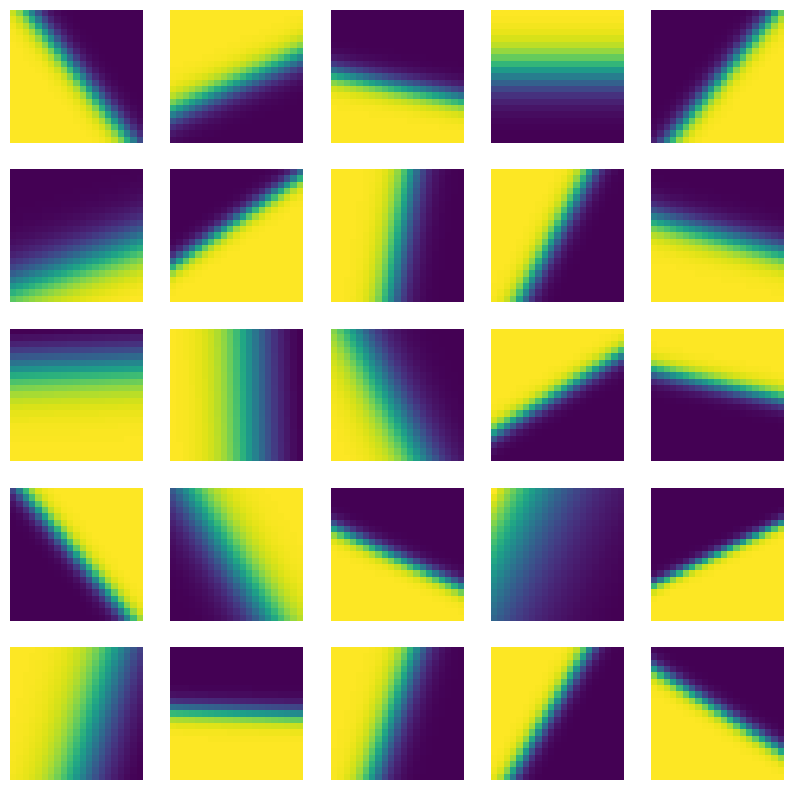

In [9]:
# Plot some of the basis functions
nplt = 25
gmin = np.min(Xd[:, :nplt])
gmax = np.max(Xd[:, :nplt])
dg = 256 / (gmax - gmin)  # rescaling constant to normalize between 0 and 256
plt.figure(figsize=(10, 10))
for jj in range(nplt):
    plt.subplot(int(np.sqrt(nplt)), int(np.sqrt(nplt)), jj + 1)
    plt.imshow((Xd[:, jj].reshape(nx, nx) - gmin) * dg, extent=[-2, 2, -2, 2], origin='lower', cmap='viridis')
    plt.axis('off')
plt.show()

## Plot the Flow Field

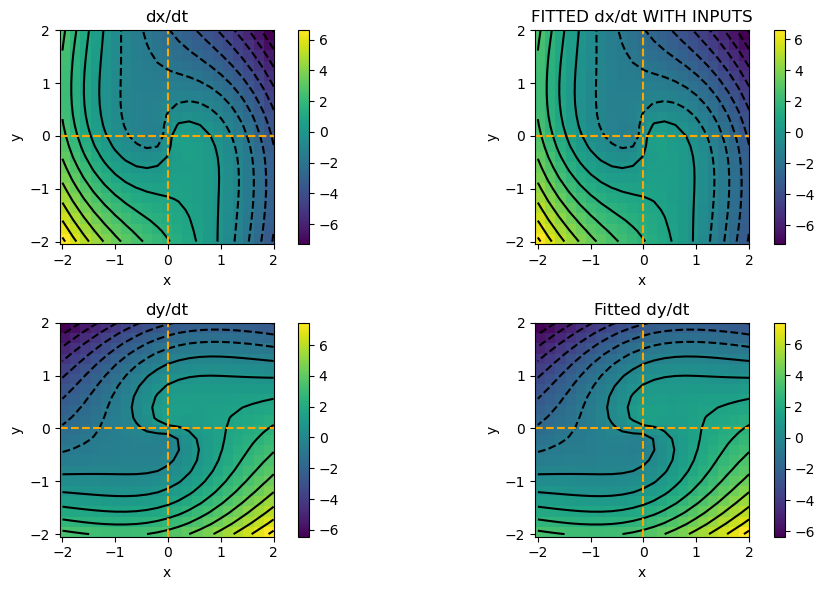

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))  # Create a 2x2 grid of subplots

# Plot 1: Gradient field for dx/dt
x = x = np.arange(-2, 2.2, 0.2)
xx, yy = np.meshgrid(x, x)
nx = len(xx)
fx = fdxdt([xx.ravel(), yy.ravel()]).reshape(nx, nx)

im1 = axs[0, 0].imshow(fx, extent=[-2.05, 2, -2.05, 2], origin='lower', aspect='equal', cmap='viridis')
axs[0, 0].contour(x, x, fx, levels=20, colors='k')
axs[0, 0].axvline(x= 0.0, color='orange', linestyle='--')
axs[0, 0].axhline(y= 0.0, color='orange', linestyle='--')
axs[0, 0].set_title('dx/dt')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
fig.colorbar(im1, ax=axs[0, 0])

# Plot 2: Gradient field for FITTED dx/dt
fx_fit = fxfit.reshape(nx, nx)
im1 = axs[0, 1].imshow(fx_fit, extent=[-2.05, 2, -2.05, 2], origin='lower', aspect='equal', cmap='viridis')
axs[0, 1].contour(x, x, fx, levels=20, colors='k')
axs[0, 1].axvline(x= 0.0, color='orange', linestyle='--')
axs[0, 1].axhline(y= 0.0, color='orange', linestyle='--')
axs[0, 1].set_title('FITTED dx/dt WITH INPUTS')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
fig.colorbar(im1, ax=axs[0, 1])



# Plot 3: Gradient field for dy/dt
fy = fdydt([xx.ravel(), yy.ravel()]).reshape(nx, nx)

im2 = axs[1, 0].imshow(fy, extent=[-2.05, 2, -2.05, 2], origin='lower', aspect='equal', cmap='viridis')
axs[1, 0].contour(x, x, fy, levels=20, colors='k')
axs[1, 0].axvline(x= 0.0, color='orange', linestyle='--')
axs[1, 0].axhline(y= 0.0, color='orange', linestyle='--')
axs[1, 0].set_title('dy/dt')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
fig.colorbar(im2, ax=axs[1, 0])

# Plot 3: Gradient field for FITTED dy/dt
fy_fit = fyfit.reshape(nx, nx)

im2 = axs[1, 1].imshow(fy_fit, extent=[-2.05, 2, -2.05, 2], origin='lower', aspect='equal', cmap='viridis')
axs[1, 1].contour(x, x, fy, levels=20, colors='k')
axs[1, 1].axvline(x= 0.0, color='orange', linestyle='--')
axs[1, 1].axhline(y= 0.0, color='orange', linestyle='--')
axs[1, 1].set_title('Fitted dy/dt')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
fig.colorbar(im2, ax=axs[1, 1])
plt.tight_layout()
plt.show()

## Check if the RNN (i.e use learned nmat) matches the output of a trajectory from the ODE

In [11]:
# Create design matrix

Xd = g(xgridvec.reshape(-1,1)@ mmat[:, 0].reshape(-1,1).T + ygridvec.reshape(-1,1)@ mmat[:, 1].reshape(-1,1).T + b.T)

# Solve for n vector using ridge regression
lambda_ = 0.001  # ridge parameter
nmat = np.linalg.solve(Xd.T @ Xd + lambda_ * np.eye(nneur), Xd.T @ Ytarg)
fxfit = Xd @ nmat[:, 0]
fyfit = Xd @ nmat[:, 1]

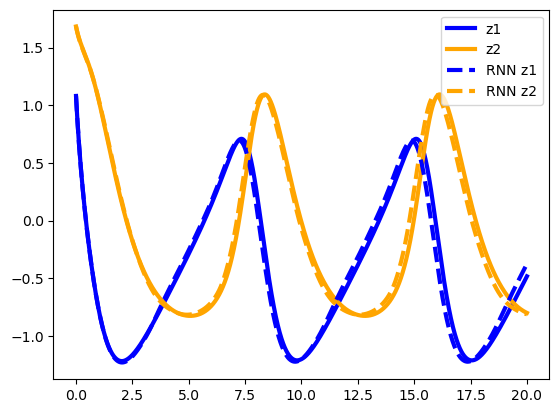

In [12]:
nd=2
dt = 0.01
nsec = 20
nT = int(nsec / dt)

rthet = np.zeros((nd, nT))
zz = np.zeros((nd, nT))
zzrnn = np.zeros((nd,nT))

# Set initial conditions
rthet[:, 0] = [2, 1]
zz[:, 0] = rthet[0, 0] * np.array([np.cos(rthet[1, 0]), np.sin(rthet[1, 0])])
zzrnn[:,0] = zz[:, 0]

Xd = g(xgridvec.reshape(-1,1)@ mmat[:, 0].reshape(-1,1).T + ygridvec.reshape(-1,1)@ mmat[:, 1].reshape(-1,1).T + b.T)

for tt in range(1, nT):

    # Rectangular coords
    zzprev = zz[:, tt - 1]
    zz[:, tt] = zzprev + dt * np.array([fdxdt(zzprev), fdydt(zzprev)])
    # zz[:, tt] = zzprev + dt * np.array([np.cos(zzprev[1, 0]), np.sin(zzprev[1, 0])])

    # Low-rank RNN (latent space)
    zprev = zzrnn[:,tt - 1]
    inner = np.tanh(zprev[0].reshape(1, -1)@ mmat[:, 0].reshape(-1,1).T + 
                    zprev[1].reshape(1, -1)@ mmat[:, 1].reshape(-1,1).T + b.T )
    # print(inner.shape)
    zzrnn[:,tt] = zprev + dt * ((nmat.T@(inner.T)).reshape(-1)) ## use this learned nmat here

tgrid = np.arange(dt, nsec+dt, dt)  # time grid
plt.plot(tgrid, zz[0,:],color='b',linewidth=3,label='z1')
plt.plot(tgrid, zz[1,:],color='orange',linewidth=3,label='z2')
plt.plot(tgrid, zzrnn[0,:],color='b',linestyle='--',linewidth=3,label='RNN z1')
plt.plot(tgrid, zzrnn[1,:],color='orange',linestyle='--',linewidth=3,label='RNN z2')
plt.legend()
plt.show()

## See how RNN fails with no inputs

In [13]:
## Create design matrix without inpputs
Xd2 = g(xgridvec.reshape(-1,1)@ mmat[:, 0].reshape(-1,1).T + ygridvec.reshape(-1,1)@ mmat[:, 1].reshape(-1,1).T )

# Solve for n vector using ridge regression
lambda_ = 0.001  # ridge parameter
nmat2 = np.linalg.solve(Xd2.T @ Xd2 + lambda_ * np.eye(nneur), Xd2.T @ Ytarg)
fxfit2 = Xd2 @ nmat2[:, 0]
fyfit2 = Xd2 @ nmat2[:, 1]

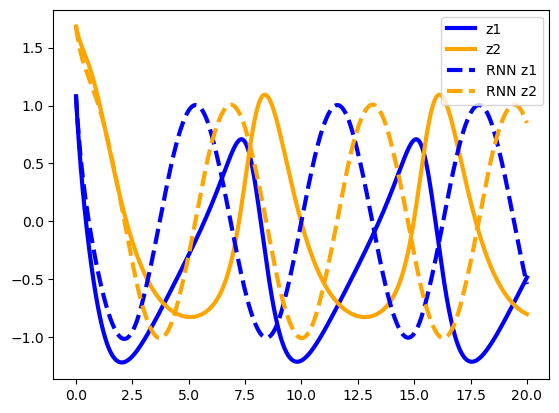

In [14]:
Xd2 = g(xgridvec.reshape(-1,1)@ mmat[:, 0].reshape(-1,1).T + ygridvec.reshape(-1,1)@ mmat[:, 1].reshape(-1,1).T)

for tt in range(1, nT):

    # Rectangular coords
    zzprev = zz[:, tt - 1]
    zz[:, tt] = zzprev + dt * np.array([fdxdt(zzprev), fdydt(zzprev)])

    # Low-rank RNN (latent space)
    zprev = zzrnn[:,tt - 1]
    inner = np.tanh(zprev[0].reshape(1, -1)@ mmat[:, 0].reshape(-1,1).T+ 
                    zprev[1].reshape(1, -1)@ mmat[:, 1].reshape(-1,1).T)
    # print(inner.shape)
    zzrnn[:,tt] = zprev + dt * ((nmat2.T@(inner.T)).reshape(-1))

tgrid = np.arange(dt, nsec+dt, dt)  # time grid
plt.plot(tgrid, zz[0,:],color='b',linewidth=3,label='z1')
plt.plot(tgrid, zz[1,:],color='orange',linewidth=3,label='z2')
plt.plot(tgrid, zzrnn[0,:],color='b',linestyle='--',linewidth=3,label='RNN z1')
plt.plot(tgrid, zzrnn[1,:],color='orange',linestyle='--',linewidth=3,label='RNN z2')
plt.legend()
plt.show()